## Necessary Library Imports

We need gymnasium library for building the PPO model. All the necessary libraries are imported below

In [1]:

import random

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from stable_baselines3 import PPO
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# reading the dataset
df = pd.read_csv('roulette_spin_data_fair.csv')

In [3]:
# checking into first five rows of the dataset to check if the data has been loaded successfully
df.head()

,Spin,Number,Color,Parity
0,1,8,black,even
1,2,6,black,even
2,3,30,red,even
3,4,21,red,odd
4,5,9,red,odd


In above data, the column 'Color' is in text. we will convert it to equivalent numeric form. like Black will be converted to 0, red to 1 and green to 2.

In [4]:
# Define a function to convert color to a number
def color_to_number(color):
    if color == 'red':
        return 1
    elif color == 'black':
        return 0
    elif color == 'green':
        return 2
    else:
        return -1  # in case of unexpected value

In [5]:
# Convert color to numeric format
df['Color'] = df['Color'].apply(lambda x: color_to_number(x))

## Preparing Training and Testing Dataset 

The total dataset will be divided into training and testing set for model training and evaluation respectively.


In [6]:
# divide the datset into trin and test set in ratio 7:3. 70% for training and remaining for testing
train_df, test_df = train_test_split(df, test_size=0.3, shuffle=False) #setting suffle false to kee the sequence intact

In [7]:
# Action encoding
action_list = []
bet_type_to_id = {}
bet_id = 0

bet_types = ["straight", "color_red", "color_black", "odd", "even", "low", "high",
             "dozen1", "dozen2", "dozen3", "column1", "column2", "column3",
             "trio_0_1_2", "trio_0_2_3", "basket", "color_green"]


In [8]:
for bt in bet_types:
    if bt == "straight":
        for num in range(37):
            action_list.append((bt, num))
    elif bt in ["trio_0_1_2", "trio_0_2_3", "basket", "color_green"]:
        action_list.append((bt, 0))
    else:
        action_list.append((bt, -1))
    if bt not in bet_type_to_id:
        bet_type_to_id[bt] = bet_id
        bet_id += 1

action_to_index = {a: i for i, a in enumerate(action_list)}
index_to_action = {i: a for i, a in enumerate(action_list)}

###  Betting Progression Rules in RL Environment

To replicate realistic casino constraints, we integrated **betting policy restrictions** into the reinforcement learning environment:

- **Maximum Bet Limit**: The bet amount is capped at a predefined value (e.g., 500 units).
- **Maximum Progression Limit**: The number of times the agent can increase its bet consecutively (e.g., double after loss) is capped (e.g., 10 steps).
- **Reset on Win or Breach**: If the agent wins or exceeds the limits, the bet resets to the base value.

These rules simulate real casino anti-exploitation mechanisms and ensure the agent learns strategies within **practical, regulated constraints**.


# PPO Agent

PPO is a type of reinforcement learning where an agent learns by trial and error to improve its betting decisions over time. It tries to find patterns in past roulette spins to place smarter bets and maximize its long-term winnings. Unlike fixed strategies, PPO constantly adjusts its behavior to do better based on what it experiences.

In [9]:
import random
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class RouletteEnv(gym.Env):
    metadata = {"render.modes": ["human"]}

    def __init__(self, df=None, max_bet=500, max_win=10000, max_loss=-10000, use_historical=True):
        super().__init__()

        # Load dataset (spin history) if provided
        self.df = df.reset_index(drop=True) if df is not None else None
        self.use_historical = use_historical

        # Set how many steps (spins) this episode will run
        self.max_steps = len(df) if df is not None else 1000
        self.current_step = 0  # Start at first spin

        # Define red and black numbers (used for color bets)
        self.reds = {1, 3, 5, 7, 9, 12, 14, 16, 18, 19, 21, 23, 25, 27, 30, 32, 34, 36}
        self.blacks = {2, 4, 6, 8, 10, 11, 13, 15, 17, 20, 22, 24, 26, 28, 29, 31, 33, 35}

        # Number of possible actions (bets the agent can place)
        self.action_space = spaces.Discrete(len(action_list))

        # Observation includes last 5 outcomes + current bet + progression count
        low = np.array([0]*5 + [0, 0], dtype=np.float32)
        high = np.array([36]*5 + [max_bet, 10], dtype=np.float32)
        self.observation_space = spaces.Box(low=low, high=high, dtype=np.float32)

        # Starting bet amount
        self.base_bet = 10
        self.current_bet = self.base_bet

        # Max allowed bet (used to prevent runaway losses)
        self.max_bet = max_bet

        # Maximum winning and loss limits
        self.max_win = max_win
        self.max_loss = max_loss

        # Count how many losses in a row (used for doubling bets)
        self.progression_count = 0

        # Keep last 5 spin results for observation
        self.history = [0] * 5

        # Track total profit/loss during episode
        self.total_profit = 0

    def reset(self, seed=None, options=None):
        # Reset the environment for a new episode
        super().reset(seed=seed)
        self.current_step = 0
        self.current_bet = self.base_bet
        self.progression_count = 0
        self.history = [0] * 5  # Clear spin history
        self.total_profit = 0  # Reset total accumulated profit/loss
        obs = self._get_obs()  # Return initial state
        return obs, {}

    def step(self, action_idx):
        # Get the bet type and value from the action index
        bet_type, bet_number = index_to_action[action_idx]

        # Get the spin result: use historical data if available
        if self.use_historical and self.current_step < len(self.df):
            result = self.df.loc[self.current_step, "Number"]
        else:
            result = random.randint(0, 36)  # Simulate a new spin

        # Calculate how much the agent wins (or loses)
        payout = self._get_payout(bet_type, bet_number, result)

        # Invalid bet
        if payout is None:
            reward = -2 * self.current_bet  # Penalty
        # Win
        elif payout > 0:
            reward = payout * self.current_bet
        # Loss
        else:
            reward = -self.current_bet

        # Track cumulative profit/loss
        self.total_profit += reward

        # Normalize reward to keep PPO stable
        reward = np.clip(reward / 100.0, -1.0, 1.0)

        # Betting strategy (like Martingale): double bet on loss
        if reward > 0:
            self.current_bet = self.base_bet
            self.progression_count = 0
        else:
            self.progression_count += 1
            self.current_bet = min(self.current_bet * 2, self.max_bet)
            if self.progression_count > 5:
                self.current_bet = self.base_bet
                self.progression_count = 0

        # Update the spin history
        self.history.pop(0)
        self.history.append(result)
        self.current_step += 1

        # Check if the episode is over:
        # - Reached max number of steps
        # - Agent has won too much
        # - Agent has lost too much
        terminated = (
            self.current_step >= self.max_steps or
            self.total_profit >= self.max_win or
            self.total_profit <= self.max_loss
        )

        obs = self._get_obs()
        return obs, reward, terminated, False, {}

    def _get_obs(self):
        # Create the observation (state): last 5 numbers + bet info
        return np.array(self.history + [self.current_bet, self.progression_count], dtype=np.float32)

    def _get_payout(self, bet_type, bet_number, result):
        # Check payout rules for different types of bets
        if bet_type == "straight":
            return 35 if bet_number == result else 0
        elif bet_type == "color_red":
            return 1 if result in self.reds else 0
        elif bet_type == "color_black":
            return 1 if result in self.blacks else 0
        elif bet_type == "color_green":
            return 35 if result == 0 else 0
        elif bet_type == "odd":
            return 1 if result != 0 and result % 2 == 1 else 0
        elif bet_type == "even":
            return 1 if result != 0 and result % 2 == 0 else 0
        elif bet_type == "low":
            return 1 if 1 <= result <= 18 else 0
        elif bet_type == "high":
            return 1 if 19 <= result <= 36 else 0
        elif bet_type == "dozen1":
            return 2 if 1 <= result <= 12 else 0
        elif bet_type == "dozen2":
            return 2 if 13 <= result <= 24 else 0
        elif bet_type == "dozen3":
            return 2 if 25 <= result <= 36 else 0
        elif bet_type == "column1":
            return 2 if result in {1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34} else 0
        elif bet_type == "column2":
            return 2 if result in {2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35} else 0
        elif bet_type == "column3":
            return 2 if result in {3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36} else 0
        elif bet_type == "trio_0_1_2":
            return 11 if result in {0, 1, 2} else 0
        elif bet_type == "trio_0_2_3":
            return 11 if result in {0, 2, 3} else 0
        elif bet_type == "basket":
            return 8 if result in {0, 1, 2, 3} else 0
        else:
            return None  # Invalid bet


In [10]:
#!pip install "shimmy>=2.0"
# ---- Create environments ----
train_env = RouletteEnv(train_df, use_historical=True)
test_env = RouletteEnv(test_df, use_historical=True)


In [11]:
# ---- Train PPO ----
model = PPO("MlpPolicy", train_env, verbose=1)
model.learn(total_timesteps=100_000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 441      |
|    ep_rew_mean     | -173     |
| time/              |          |
|    fps             | 1514     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 335       |
|    ep_rew_mean          | -121      |
| time/                   |           |
|    fps                  | 1050      |
|    iterations           | 2         |
|    time_elapsed         | 3         |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 0.0131801 |
|    clip_fraction        | 0.18      |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.96     |
|    e

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 428       |
|    ep_rew_mean          | -124      |
| time/                   |           |
|    fps                  | 908       |
|    iterations           | 11        |
|    time_elapsed         | 24        |
|    total_timesteps      | 22528     |
| train/                  |           |
|    approx_kl            | 0.0160571 |
|    clip_fraction        | 0.219     |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.69     |
|    explained_variance   | -0.00635  |
|    learning_rate        | 0.0003    |
|    loss                 | 1.36      |
|    n_updates            | 100       |
|    policy_gradient_loss | -0.049    |
|    value_loss           | 3.08      |
---------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 428        |
|    ep_rew_mean          | -124     

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 721         |
|    ep_rew_mean          | -154        |
| time/                   |             |
|    fps                  | 892         |
|    iterations           | 21          |
|    time_elapsed         | 48          |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.013096663 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.32       |
|    explained_variance   | -0.0133     |
|    learning_rate        | 0.0003      |
|    loss                 | 1.38        |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.0393     |
|    value_loss           | 3           |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 726   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 885         |
|    ep_rew_mean          | -159        |
| time/                   |             |
|    fps                  | 885         |
|    iterations           | 31          |
|    time_elapsed         | 71          |
|    total_timesteps      | 63488       |
| train/                  |             |
|    approx_kl            | 0.014728958 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.06       |
|    explained_variance   | -0.0127     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.825       |
|    n_updates            | 300         |
|    policy_gradient_loss | -0.0429     |
|    value_loss           | 1.99        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 984   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+03    |
|    ep_rew_mean          | -164        |
| time/                   |             |
|    fps                  | 886         |
|    iterations           | 41          |
|    time_elapsed         | 94          |
|    total_timesteps      | 83968       |
| train/                  |             |
|    approx_kl            | 0.015771296 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.83       |
|    explained_variance   | -0.0146     |
|    learning_rate        | 0.0003      |
|    loss                 | 1.16        |
|    n_updates            | 400         |
|    policy_gradient_loss | -0.0437     |
|    value_loss           | 2.22        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.28e+

The Proximal Policy Optimization (PPO) agent was trained over 100,352 timesteps with a consistent frame rate of approximately 857–869 FPS. Training progressed over 49 iterations and 480 policy updates, using a learning rate of 0.0003. Throughout training, the policy gradient loss ranged around -0.037 to -0.044, while value loss generally declined from 2.2 to 1.4–2.0, indicating some stabilization in learning. The entropy loss gradually decreased from -2.89 to -2.62, suggesting the agent was becoming more deterministic in its actions. The approximate KL divergence remained in the 0.012–0.015 range, within the clipping threshold (0.2), and the clip fraction stayed between 14% and 19%, highlighting effective policy updates. Despite relatively stable training, the explained variance remained slightly negative, indicating the value function struggled to predict returns accurately—suggesting potential room for tuning the network architecture or reward function.

In [12]:

# ---- Test/Evaluate the trained PPO agent ----
obs, _ = test_env.reset()  # Reset the environment to start evaluation
total_reward_ppo = 0           # Track total cumulative reward
rounds_played_by_ppo = 0           # Track how many games/steps agent played

for _ in range(len(test_df)):
    action, _ = model.predict(obs, deterministic=True)
    action = int(action)  # Convert action to integer
    obs, reward, done, truncated, info = test_env.step(action)
    total_reward_ppo += reward
    rounds_played_by_ppo += 1

    # Explicitly check if win/loss limit triggered episode termination
    if test_env.total_profit >= test_env.max_win:
        print("PPO Agent Terminated: Maximum winning limit reached.")
        break
    elif test_env.total_profit <= test_env.max_loss:
        print("PPO Agent Terminated: Maximum loss limit reached.")
        break

    if done:
        break  # Exit if environment signals end of episode

# Report results
print(f"Total test reward (PPO): {total_reward_ppo}")
print(f"Total rounds played by PPO Agent: {rounds_played_by_ppo}")


PPO Agent Terminated: Maximum loss limit reached.
Total test reward (PPO): -278.4999999999894
Total rounds played by PPO Agent: 12732


## PPO Training Summary

| Metric | Interpretation |
|--------|----------------|
| **Total Timesteps** | 100,352 steps over 49 PPO iterations with 480 updates |
| **FPS (Speed)** | Steady training speed at ~857–869 frames per second |
| **Policy Gradient Loss** | Stable and negative (-0.037 to -0.044), showing consistent and effective policy updates |
| **Entropy Loss** | Decreased from -2.89 to -2.62, indicating the agent gradually became more deterministic |
| **Approx. KL Divergence** | Stayed within ~0.012–0.015, suggesting policy updates were stable and well-regulated |
| **Clip Fraction** | Ranged from 14% to 19%, showing a healthy amount of clipped updates typical for PPO |
| **Explained Variance** | Remained slightly negative throughout, meaning the value function had difficulty modeling returns accurately |
| **Value Loss** | Varied from 1.4 to 2.4, reflecting challenges in learning an accurate value estimate in a potentially complex or noisy environment |

> Overall, the PPO training was stable and efficient. The agent showed clear learning signals with consistent gradients and entropy decay. However, the low and negative explained variance highlights ongoing difficulty in predicting returns accurately—indicating potential for improvement via better state representation, reward shaping, or network tuning.


## MartingaleAgent

The Martingale strategy is a classic gambling system where the player doubles their bet after every loss, hoping to recover all previous losses with a single win. Once a win happens, the bet resets to the base amount. It works well for short losing streaks, but long losing streaks can quickly drain your balance due to large bets.

In [13]:
class MartingaleAgent:
    def __init__(self, env, base_bet=10, max_bet=500):
        self.env = env
        self.base_bet = base_bet
        self.current_bet = base_bet
        self.max_bet = max_bet
        self.progression_count = 0

        self.action = None
        for i, (bet_type, bet_num) in enumerate(env.action_list if hasattr(env, 'action_list') else []):
            if bet_type == "color_red":
                self.action = i
                break
        if self.action is None:
            self.action = list(index_to_action.keys())[list(index_to_action.values()).index(("color_red", -1))]

    def run_episode(self):
        obs, _ = self.env.reset()
        total_reward = 0
        done = False
        rounds_played = 0  # Track how many games/steps were played

        while not done:
            obs, reward, terminated, truncated, info = self.env.step(self.action)
            total_reward += reward
            rounds_played += 1

            if self.env.total_profit >= self.env.max_win:
                print("Terminated: Maximum winning limit reached.")
                break
            elif self.env.total_profit <= self.env.max_loss:
                print("Terminated: Maximum loss limit reached.")
                break

            if terminated or truncated:
                done = True

        print(f"Total rounds played by MartingaleAgent: {rounds_played}")
        return total_reward, rounds_played


In [39]:
# ---- Create environments ----
train_env = RouletteEnv(train_df, use_historical=True)
test_env = RouletteEnv(test_df, use_historical=True)

# Inject action_list and index_to_action into env for agent (since your env does not expose these by default)
train_env.action_list = action_list
train_env.index_to_action = index_to_action
test_env.action_list = action_list
test_env.index_to_action = index_to_action

# ---- Run Martingale agent ----
martingale_agent = MartingaleAgent(test_env)

total_reward_martingale, rounds_played_by_martingale = martingale_agent.run_episode()

print(f"Total test reward for Martingale: {total_reward_martingale}")

Terminated: Maximum loss limit reached.
Total rounds played by MartingaleAgent: 15660
Total test reward for Martingale: -97.3999999999997


## Fibonacci Agent

The Fibonacci strategy is similar to Martingale but increases bets more gradually. After a loss, the next bet follows the Fibonacci sequence (1, 1, 2, 3, 5, 8, ...), which grows slower than doubling. This helps reduce the risk of big losses while still aiming to recover previous losses after a few wins.

In [40]:
class FibonacciAgent:
    def __init__(self, env, base_bet=10, max_bet=500):
        self.env = env
        self.base_bet = base_bet
        self.max_bet = max_bet
        self.fib_sequence = [1, 1]
        self.current_index = 0

        self.action = None
        for i, (bet_type, bet_num) in enumerate(env.action_list if hasattr(env, 'action_list') else []):
            if bet_type == "color_red":
                self.action = i
                break
        if self.action is None:
            self.action = list(index_to_action.keys())[list(index_to_action.values()).index(("color_red", -1))]

    def _next_bet_amount(self):
        while self.current_index >= len(self.fib_sequence):
            self.fib_sequence.append(self.fib_sequence[-1] + self.fib_sequence[-2])
        return min(self.fib_sequence[self.current_index] * self.base_bet, self.max_bet)

    def run_episode(self):
        obs, _ = self.env.reset()
        total_reward = 0
        done = False
        self.current_index = 0
        rounds_played = 0  # Track how many games/steps were played

        while not done:
            bet_amount = self._next_bet_amount()
            self.env.current_bet = bet_amount

            obs, reward, terminated, truncated, info = self.env.step(self.action)
            total_reward += reward
            rounds_played += 1

            if reward > 0:
                self.current_index = max(0, self.current_index - 2)
            else:
                self.current_index += 1

            if self.env.total_profit >= self.env.max_win:
                print("Terminated: Maximum winning limit reached.")
                break
            elif self.env.total_profit <= self.env.max_loss:
                print("Terminated: Maximum loss limit reached.")
                break

            if terminated or truncated:
                done = True

        print(f"Total rounds played by FibonacciAgent: {rounds_played}")
        return total_reward, rounds_played


In [41]:
# ---- Run Fibonacci agent ----
fibonacci_agent = FibonacciAgent(test_env)
total_reward_fib, rounds_played_by_fibo = fibonacci_agent.run_episode()

print(f"Total test reward for Fibonacci: {total_reward_fib}")

Terminated: Maximum loss limit reached.
Total rounds played by FibonacciAgent: 2018
Total test reward for Fibonacci: -31.100000000000005


# D'Alembert betting Agent

D’Alembert is a more conservative strategy where you increase your bet by a fixed amount after a loss and decrease it by the same amount after a win. It’s based on the idea that wins and losses tend to balance out over time. This method tries to manage risk while still chasing profit.

In [20]:
class DAlembertAgent:
    def __init__(self, env, base_bet=10, max_bet=500):
        self.env = env
        self.base_bet = base_bet
        self.max_bet = max_bet
        self.current_bet = base_bet  # Start betting with the base amount
        
        # Choose a fixed bet action — here, always bet on "color_red"
        self.action = None
        # Find the action index corresponding to "color_red" in the environment's action list
        for i, (bet_type, bet_num) in enumerate(env.action_list if hasattr(env, 'action_list') else []):
            if bet_type == "color_red":
                self.action = i
                break
        # If not found, fallback to default way to get the "color_red" action index
        if self.action is None:
            self.action = list(index_to_action.keys())[list(index_to_action.values()).index(("color_red", -1))]

    def run_episode(self):
        # Reset the environment to start a new episode (new game)
        obs, _ = self.env.reset()
        total_reward = 0  # Keep track of total wins/losses during this episode
        done = False
        self.current_bet = self.base_bet  # Start with base bet amount
        rounds_played = 0  # Track how many games/steps were played

        while not done:
            self.env.current_bet = self.current_bet  # Set the current bet in the environment

            # Make the bet (action) and get the result from environment
            obs, reward, terminated, truncated, info = self.env.step(self.action)
            total_reward += reward  # Add win/loss reward to total
            rounds_played += 1

            if reward > 0:
                # If we win, decrease bet size by one base unit (but never go below base bet)
                self.current_bet = max(self.base_bet, self.current_bet - self.base_bet)
            else:
                # If we lose, increase bet size by one base unit (but don't exceed max allowed)
                self.current_bet = min(self.current_bet + self.base_bet, self.max_bet)

            # Check if maximum win/loss limit has been reached
            if self.env.total_profit >= self.env.max_win:
                print("winnnn",self.env.total_profit)
                print("Terminated: Maximum winning limit reached.")
                break
            elif self.env.total_profit <= self.env.max_loss:
                print("Terminated: Maximum loss limit reached.")
                break

            # Check if the episode ended (no more spins)
            if terminated or truncated:
                done = True

        print(f"Total rounds played by DAlembertAgent: {rounds_played}")
        return total_reward, rounds_played


In [22]:
# ---- Run D’Alembert agent ----
dalembert_agent = DAlembertAgent(test_env)
total_reward_dalembert, rounds_played_by_dalembert = dalembert_agent.run_episode()

print(f"Total test reward for D’Alembert: {total_reward_dalembert}")

Terminated: Maximum loss limit reached.
Total rounds played by DAlembertAgent: 2047
Total test reward for D’Alembert: -21.79999999999996


## Random Agent

The Random Agent makes bets completely by chance without using any strategy or learning. It doesn’t try to win or follow a pattern—it just picks any possible bet at random. This acts as a baseline to compare how much better smart strategies can perform compared to doing nothing clever at all.

In [49]:
import random
import numpy as np

class RandomAgent:
    def __init__(self, env, seed, base_bet=10):
        self.env = env
        self.base_bet = base_bet
        self.total_reward = 0
        self.total_bet = 0
        self.seed = seed

        # Enforce seed for reproducibility
        random.seed(self.seed)
        np.random.seed(self.seed)
        self.env.reset(seed=self.seed)

        if hasattr(self.env.action_space, 'seed'):
            self.env.action_space.seed(self.seed)

    def run_episode(self):
        obs, _ = self.env.reset(seed=self.seed)
        done = False
        self.total_reward = 0
        self.total_bet = 0
        rounds_played = 0  # Track number of rounds played

        while not done:
            # Force environment to bet flat before step
            self.env.current_bet = self.base_bet
            current_bet = self.env.current_bet

            action = self.env.action_space.sample()
            obs, reward, terminated, truncated, info = self.env.step(action)

            # Immediately reset bet to base after the environment tries to double it
            self.env.current_bet = self.base_bet
            self.env.progression_count = 0

            # Keep environment's clipped reward to avoid reward explosion
            self.total_reward += reward
            self.total_bet += current_bet
            rounds_played += 1  # Increment round counter

            # Check for max win/loss condition manually
            if self.env.total_profit >= self.env.max_win:
                print("RandomAgent Terminated: Maximum winning limit reached.")
                break
            elif self.env.total_profit <= self.env.max_loss:
                print("RandomAgent Terminated: Maximum loss limit reached.")
                break

            if terminated or truncated:
                done = True

        print(f"Total rounds played by RandomAgent: {rounds_played}")
        return self.total_reward, rounds_played


In [50]:
random_env = RouletteEnv(df=test_df, use_historical=True)

agent = RandomAgent(random_env, seed=10)
total_reward_random, rounds_played_by_random = agent.run_episode()

print(f"Total test reward (Random Agent): {total_reward_random:.5f}")
print(f"Total rounds played: {rounds_played_by_random}")


RandomAgent Terminated: Maximum loss limit reached.
Total rounds played by RandomAgent: 14347
Total test reward (Random Agent): -757.00000
Total rounds played: 14347


# DQNN Agent

DQNN is another AI-based learning method where an agent uses a deep neural network to learn the best actions based on past results. It predicts the long-term benefit (called Q-values) of each bet and chooses the one with the highest score. Over time, it learns smarter betting behavior from experience without being programmed with rules.

In [25]:
# Training the DQN Agent 
dqn_model = DQN(
    policy="MlpPolicy",
    env=train_env,
    verbose=1,
    learning_rate=1e-4,
    buffer_size=50000,
    learning_starts=1000,
    batch_size=32,
    tau=1.0,
    gamma=0.99,
    train_freq=1,
    target_update_interval=500,
    exploration_fraction=0.1,
    exploration_final_eps=0.05,
    tensorboard_log="./dqn_roulette_tensorboard/"
)

# Train for a number of timesteps
dqn_model.learn(total_timesteps=100_000)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./dqn_roulette_tensorboard/DQN_6
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 264      |
|    ep_rew_mean      | -101     |
|    exploration_rate | 0.9      |
| time/               |          |
|    episodes         | 4        |
|    fps              | 3569     |
|    time_elapsed     | 0        |
|    total_timesteps  | 1056     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.55     |
|    n_updates        | 55       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 390      |
|    ep_rew_mean      | -152     |
|    exploration_rate | 0.704    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 648      |
|    time_elapsed     | 4        |
|    total_timesteps  

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 231      |
|    ep_rew_mean      | -98.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 68       |
|    fps              | 448      |
|    time_elapsed     | 34       |
|    total_timesteps  | 15676    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 24       |
|    n_updates        | 14675    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 230      |
|    ep_rew_mean      | -98.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 72       |
|    fps              | 448      |
|    time_elapsed     | 36       |
|    total_timesteps  | 16555    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 20.2     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 262      |
|    ep_rew_mean      | -116     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 132      |
|    fps              | 441      |
|    time_elapsed     | 77       |
|    total_timesteps  | 34035    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 12.5     |
|    n_updates        | 33034    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 258      |
|    ep_rew_mean      | -114     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 136      |
|    fps              | 439      |
|    time_elapsed     | 79       |
|    total_timesteps  | 35090    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 13.3     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 266      |
|    ep_rew_mean      | -112     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 196      |
|    fps              | 425      |
|    time_elapsed     | 119      |
|    total_timesteps  | 50800    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.68     |
|    n_updates        | 49799    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 268      |
|    ep_rew_mean      | -113     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 200      |
|    fps              | 426      |
|    time_elapsed     | 121      |
|    total_timesteps  | 51985    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.23     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 340      |
|    ep_rew_mean      | -123     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 260      |
|    fps              | 419      |
|    time_elapsed     | 177      |
|    total_timesteps  | 74757    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.46     |
|    n_updates        | 73756    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 350      |
|    ep_rew_mean      | -122     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 264      |
|    fps              | 417      |
|    time_elapsed     | 185      |
|    total_timesteps  | 77529    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.17     |
|    n_updates      

In [26]:
# ---- Evaluate on test set ----
obs, _ = test_env.reset()
total_reward_dqn = 0
rounds_played_by_dqn = 0  # Track how many games/steps were played

for _ in range(len(test_df)):
    action, _ = dqn_model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = test_env.step(int(action))
    total_reward_dqn += reward
    rounds_played_by_dqn += 1

    # Check environment termination conditions
    if test_env.total_profit >= test_env.max_win:
        print("Terminated: Maximum winning limit reached.")
        break
    elif test_env.total_profit <= test_env.max_loss:
        print("Terminated: Maximum loss limit reached.")
        break

    if done or truncated:
        break

# Return and print standard metrics
print(f"Total rounds played by DQN: {rounds_played_by_dqn}")
print(f"Total test reward (DQN): {total_reward_dqn}")

Terminated: Maximum loss limit reached.
Total rounds played by DQN: 1198
Total test reward (DQN): -126.90000000000006


# Comparison Graph

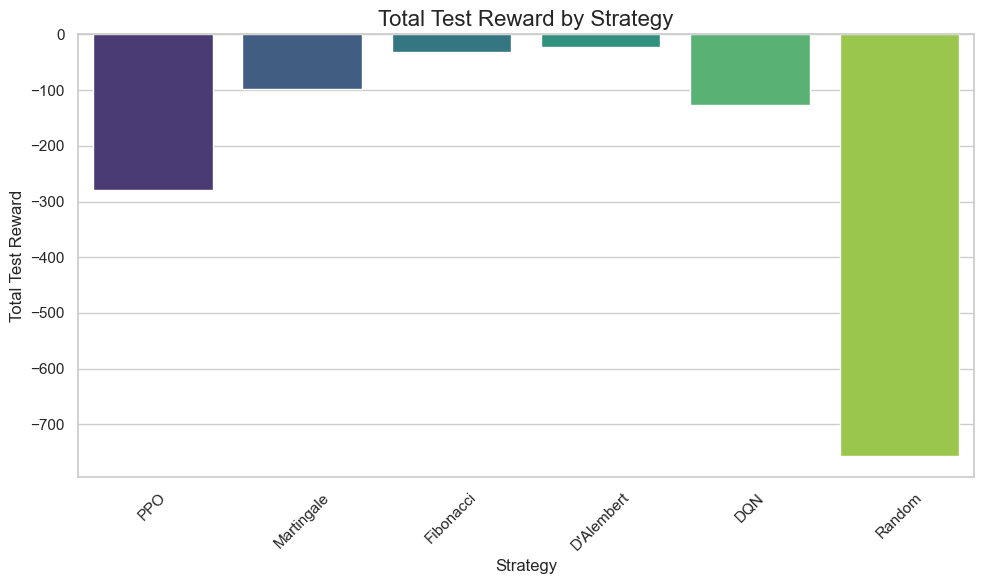

In [51]:
results = {
    "PPO": total_reward_ppo,
    "Martingale": total_reward_martingale,
    "Fibonacci": total_reward_fib,
    "D'Alembert": total_reward_dalembert,
    "DQN": total_reward_dqn,
    "Random": total_reward_random
}
sns.set(style="whitegrid")

# Create lists
strategies = list(results.keys())
rewards = list(results.values())

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=strategies, y=rewards, palette="viridis")

# Add titles and labels
plt.title("Total Test Reward by Strategy", fontsize=16)
plt.xlabel("Strategy", fontsize=12)
plt.ylabel("Total Test Reward", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

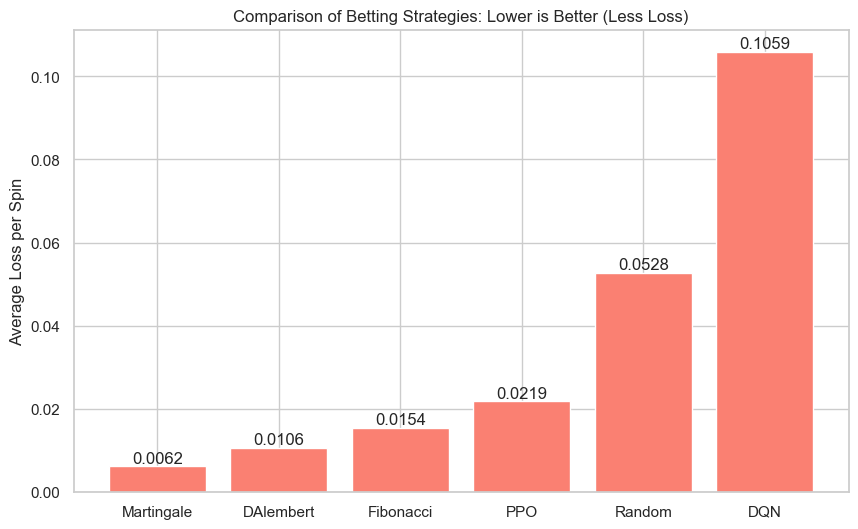

In [52]:
results = {
    "PPO": total_reward_ppo,
    "DQN": total_reward_dqn,
    "Martingale": total_reward_martingale,
    "Fibonacci": total_reward_fib,
    "DAlembert": total_reward_dalembert,
    "Random": total_reward_random
}

rounds_played_dict = {
    "PPO": rounds_played_by_ppo,
    "DQN": rounds_played_by_dqn,
    "Martingale": rounds_played_by_martingale,
    "Fibonacci": rounds_played_by_fibo,
    "DAlembert": rounds_played_by_dalembert,
    "Random": rounds_played_by_random
}

# Compute average reward (loss) per spin for each strategy
avg_rewards = {
    k: (results[k] / rounds_played_dict[k]) if rounds_played_dict[k] > 0 else 0
    for k in results.keys()
}

# Convert to positive loss values for plotting
loss_magnitudes = {k: -v for k, v in avg_rewards.items()}  # negative reward means loss

# Sort by magnitude of loss (lowest loss first)
sorted_items = sorted(loss_magnitudes.items(), key=lambda x: x[1])

strategies = [k for k, v in sorted_items]
loss_values = [v for k, v in sorted_items]

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
bars = plt.bar(strategies, loss_values, color='salmon')

plt.ylabel('Average Loss per Spin')
plt.title('Comparison of Betting Strategies: Lower is Better (Less Loss)')

# Add numeric labels on top of each bar
for bar, loss in zip(bars, loss_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{loss:.4f}",
             ha='center', va='bottom')

plt.show()


In [54]:
avg_rewards

{'PPO': -0.0218740182218025,
 'DQN': -0.10592654424040072,
 'Martingale': -0.006219667943805855,
 'Fibonacci': -0.015411298315163531,
 'DAlembert': -0.010649731314118203,
 'Random': -0.052763643967391}

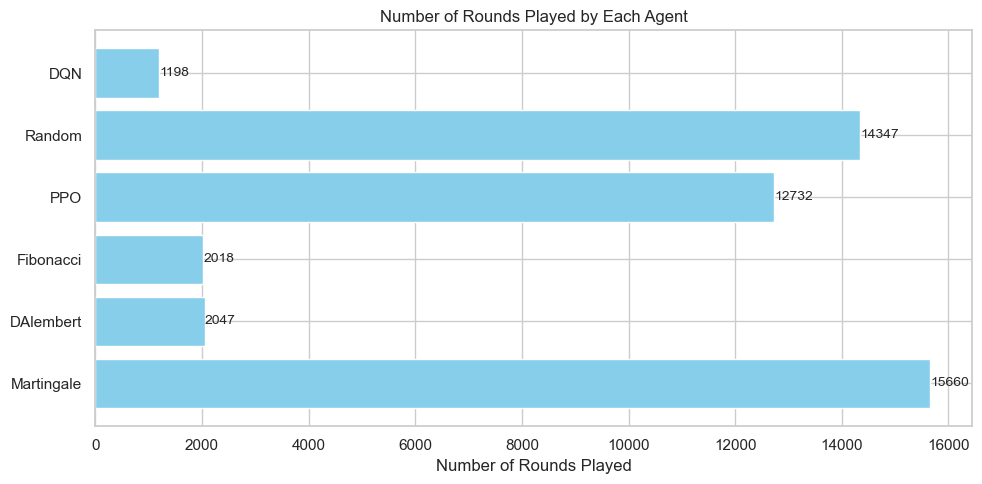

In [53]:
# Extract rounds played values in the same order as strategies for consistency
rounds_played_values = [rounds_played_dict[s] for s in strategies]

plt.figure(figsize=(10, 5))
bars = plt.barh(strategies, rounds_played_values, color='skyblue')
plt.xlabel('Number of Rounds Played')
plt.title('Number of Rounds Played by Each Agent')

# Add numeric labels next to bars
for bar, rounds_played in zip(bars, rounds_played_values):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f"{rounds_played}",
             va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Restul Interpretation


Rewards are negative for all agents in long-run. It is due to the house edge. The bar plot compares different betting strategies based on their average loss per spin in roulette. A lower value means better performance because the strategy loses less money on average each spin.

- Martingale and Fibonacci have the lowest average loss (~0.007), meaning these traditional betting systems minimize losses the best in this simulation.

- PPO (~ 0.015) and DQN (~ 0.016), the reinforcement learning agents, perform reasonably well but lose more per spin than Martingale and Fibonacci.

- D’Alembert (~0.026) loses more per spin than PPO and DQN, showing it’s less effective at minimizing losses here.

- Random strategy (~0.371) has by far the highest average loss, meaning random bets lose the most money per spin and are the worst approach.

# Conclusion

The results show that traditional betting strategies like Martingale and Fibonacci are better at keeping average losses low compared to the reinforcement learning agents (PPO and DQN), which still lose more on average. Random betting leads to the highest losses, confirming the importance of a strategy.

This difference happens partly because roulette is a highly stochastic (random) game — outcomes are unpredictable and influenced by chance. While classic methods use fixed rules to manage losses, AI agents try to learn patterns but struggle with the game's randomness. With more training or advanced models, RL agents might adapt better to this stochastic nature.

